# Assignment 5: Neuroevolution

**Goal**: Implement an Evolutionary Algorithm to optimize an Artificial Neural Network (ANN) based controller for the CartPole task in OpenAI Gym environment.

CartPole evaluation environment functions are provided. Your goal is to implement your ANN to control the cartpole and use your Evolutionary Algorithm to optimize the ANN parameters (weights).

Please answer the `Questions` and implement coding `Tasks` by filling **PLEASE FILL IN** sections. *Documentation* of your code is also important. You can find the grading scheme in implementation cells.

  * Plagiarism is automatically checked and set to **0 points**

  * It is allowed to learn from external resources but copying is not allowed. If you use any external resource, please cite them in the comments (e.g. `# source: https://...../` (see `fitness_function`))

**Install Prerequisites**

In [1]:
# Run this cell to install the required libraries
# %pip install numpy matplotlib scipy

**Imports**

In [2]:
# Necessary libraries
import matplotlib.pyplot as plt


In [3]:
# Enables inline matplotib graphs
%matplotlib inline
# Comment the line above and uncomment the lines below to have interactive plots
# WARN: may cause dependency issues
# %matplotlib qt5
# %pip install PyQt5
# plt.ion()

In [4]:
%pip install gymnasium
import gymnasium as gym

Note: you may need to restart the kernel to use updated packages.


---
**Question 1 (0-0.25-0.5 pt):** Following link provides more information about the CartPole environemnt we would like to find an ANN to control: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Please have a look at the link and note the observation and action spaces, how many dimensions they have? Are they continous or discrete, and what kinds of value they can get?

**Answer:** Observation spaces have ```4``` continuous dimensions, which are "Cart Position", "Cart Velocity", "Pole Angle" and "Pole Angular Velocity". "Cart Position" has value from ```-4.8``` to ```4.8```; "Cart Velocity" has no bounds; "Pole Angle" has value from ```-0.418 (-24°)``` to ```0.418 (24°)```; "Pole Angular Velocity" has no bounds.
Action spaces have ```2``` discrete dimensions with values of ```0 (Push cart to the left)``` and ```1 (Push cart to the right)```.

---
**Question 2 (0-0.25-0.5 pt):** What is your proposed ANN architecture and why? Please also discuss the activation functions you choose.

**Answer:** This Artificial Neural Network consists of an input layer, a hidden layer and an output layer. The input layer has `inp` neurons, the hidden layer has `hid` neurons and the output layer has `out` neurons. The neurons in each layer have a weight matrix and a bias vector which are randomly initialized.
This is a genetic algorithm problem, the weights and biases of this neural network can be considered as chromosomes and the genetic algorithm optimizes the performance of the neural network by optimizing these chromosomes. My reason for using `tanh` as an activation function is that it maps the values of the inputs between -1 and 1 and the average output is close to 0, which can make the learning process more stable. Additionally, the derivative of the `tanh` function is close to 1 when the absolute value of the input is small, which means that in these regions the neuron's errors can be efficiently back-propagated.

---
**Task 1: Implementation of Evolutionary Algrotihm (0-1.6-3.8-4.2-5 pt):** Implement your evolutionary algorithm to find an ANN controller for the CartPole task.

In [5]:
#################################
# Grading
# 0 pts if the code does not work, code works but it is fundamentally incorrect
# 1.6 pts if the code works but some functions are incorrect and it is badly explained
# 3.8 pts if the code works but some functions are incorrect but it is explained well
# 4.2 pts if the code works very well aligned with the task without any mistakes, but it is badly explained
# 5 pts if the code works very well aligned with the task without any mistakes, and it is well explained
################################################################
"""
    Source of fitness funtion: https://github.com/Tao-Yida/VU-CI-Assignment2024/blob/main/assignment_2.ipynb
"""

import numpy as np

# Artificial Neural Network parameters (weights)
# See here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for input and output space
# PLEASE SPECIFY BELOW
inp = 4  # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
hid = 10
out = 1  # action: left or right


###################
# Define the ANN structure
class ANN:
    def __init__(self, inp, hid, out):
        self.inp = inp
        self.hid = hid
        self.out = out
        self.weights1 = np.random.randn(self.inp, self.hid)
        self.weights2 = np.random.randn(self.hid, self.out)
        self.bias1 = np.random.randn(self.hid)
        self.bias2 = np.random.randn(self.out)

    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.tanh(self.z2)
        return self.a2

    def tanh(self, s):
        return np.tanh(s)


# Open AI gym environment
env = gym.make("CartPole-v1")


# CartPole evaluation function
def cartpole(x):
    ann = ANN(inp, hid, out)
    ann.weights1 = x[: inp * hid].reshape(
        inp, hid
    )  # Extract inp*hid weights from x and reshape to (inp, hid)
    ann.weights2 = x[inp * hid : inp * hid + hid * out].reshape(hid, out)
    ann.bias1 = x[
        inp * hid + hid * out : inp * hid + hid * out + hid
    ]  # Extract hid biases from x
    ann.bias2 = x[-out:]  # Extract last out biases from x

    # Reset environment
    observation, info = env.reset(seed=0)

    rew = 0  # Initial reward
    step = 0  # step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step < 1000:  # run nStep number of time
        action_prob = ann.forward(observation)
        action = 0 if action_prob < 0 else 1  # negative: 0 (left), positive: 1 (right)

        observation, reward, done, tr, info = env.step(action)
        step += 1
        rew = rew + reward

        # If the parameters are beyond thresholds.
        cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation
        if abs(cart_position) > 4.8 or abs(pole_angle) > 0.418:
            done = True
        # print(f"Step: {step}, Observation: {observation}, Action: {action}, Reward: {reward}, Total Reward: {rew}")

    env.close()
    return np.minimum(
        maxStep, rew
    )  # return the reward or maxStep (if maxStep < 1000, this means that pole fell)


# CartPole evaluation function with video recording
def cartpole_record_video(x):
    tmp_env = gym.make("CartPole-v1", render_mode="rgb_array")

    # Video recording function - be sure to check the folder path - you should see the video here:content/video/cartpole
    env = gym.wrappers.RecordVideo(
        env=tmp_env, video_folder="content/video/cartpole", name_prefix="cartpole"
    )

    ann = ANN(inp, hid, out)
    ann.weights1 = x[: inp * hid].reshape(inp, hid)
    ann.weights2 = x[inp * hid : inp * hid + hid * out].reshape(hid, out)
    ann.bias1 = x[inp * hid + hid * out : inp * hid + hid * out + hid]
    ann.bias2 = x[-out:]

    # Reset environment
    observation, info = env.reset(seed=0)

    rew = 0  # Initial reward
    step = 0  # step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step < 1000:  # run nStep number of time
        action_prob = ann.forward(observation)
        action = 0 if action_prob < 0 else 1

        # action should be provided based on the output of the artificial neural network
        observation, reward, done, tr, info = env.step(action)
        step += 1  # step counter
        rew = rew + reward  # after each step increment reward
        env.render()

    env.close_video_recorder()
    env.close()
    return np.minimum(
        maxStep, rew
    )  # return the reward or maxStep (if maxStep < 1000, this means that pole fell)


# CartPole evaluation function for visualizing the cartpole environment
def cartpole_visualize(x):
    tmp_env = gym.make("CartPole-v1", render_mode="human")

    ann = ANN(inp, hid, out)
    ann.weights1 = x[: inp * hid].reshape(inp, hid)
    ann.weights2 = x[inp * hid : inp * hid + hid * out].reshape(hid, out)
    ann.bias1 = x[inp * hid + hid * out : inp * hid + hid * out + hid]
    ann.bias2 = x[-out:]

    # Reset environment
    observation, info = tmp_env.reset(seed=0)

    rew = 0  # Initial reward
    step = 0  # step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step < 1000:  # run nStep number of time
        action_prob = ann.forward(observation)
        action = 0 if action_prob < 0.5 else 1

        # action should be provided based on the output of the artificial neural network
        observation, reward, done, tr, info = tmp_env.step(action)
        step += 1  # step counter
        rew = rew + reward  # after each step increment reward
        tmp_env.render()

    tmp_env.close()
    return np.minimum(
        maxStep, rew
    )  # return the reward or maxStep (if maxStep < 1000, this means that pole fell)


def initialization(population_size, num_dimensions):
    """
    Initialize the starting population with random individuals.
    Each gene of an individual corresponds to the weights and offsets of an ANN.
    """
    # Create an initial population of size (population_size, num_dimensions), row is an individual, column is a dimension(gene).
    x = np.random.uniform(low=-1, high=1, size=(population_size, num_dimensions))
    return x  # Return population


def evaluation(x, objective_function):
    """Evaluate the fitness of the population members."""
    fitness = np.apply_along_axis(objective_function, 1, x)
    return fitness


def crossover(x_parents, p_crossover):
    """Perform crossover to create offsprings."""
    offspring = []
    n_parents = x_parents.shape[0]
    n_dimension = x_parents.shape[1]

    for _ in range(n_parents // 2):
        # Randomly select two parents
        parents_indices = np.random.choice(range(n_parents), size=2, replace=False)

        if np.random.rand() < p_crossover:
            # Exchange genes at a random crossover point
            crossover_point = np.random.randint(1, n_dimension)

            # Create offspring by combining genes from selected parents
            parent1 = x_parents[parents_indices[0]]
            parent2 = x_parents[parents_indices[1]]
            # Perform crossover, the first child gets the first part of parent1 and the second part of parent2, and vice versa
            child1 = np.hstack((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.hstack((parent2[:crossover_point], parent1[crossover_point:]))

            offspring.append(child1)
            offspring.append(child2)
        else:
            # If no crossover was done, just pass parents to the next generation
            offspring.extend(x_parents[parents_indices])

    return np.array(offspring)


def mutation(x, m_rate):
    """Apply mutation to an individual."""
    for _ in range(len(x)):
        if np.random.rand() < m_rate:

            # Randomly select a gene to mutate
            gene_idx = np.random.randint(len(x))

            # Mutate the selected gene with a random value within the boundaries
            x[gene_idx] = np.random.uniform(-1, 1)
    return x


def parent_selection(x, f):
    """Select parents for the next generation
    Two methods can be used: select the best individual or randomly select individuals for the tournament.
    """
    tournament_size = 3  # Number of individuals participating in the tournament, the best one/a random one will be selected
    x_parents = []
    f_parents = []

    # Assume the population size of parents is the same as the population size of the current generation
    while len(x_parents) < len(x):
        indices = np.random.choice(range(len(x)), size=tournament_size, replace=False)

        # Select randomly
        parents_idx = np.random.choice(indices)

        # Append the best individual to the parents
        # parents_idx = indices[np.argmax(f[indices])]

        x_parents.append(x[parents_idx])
        f_parents.append(f[parents_idx])

    return np.array(x_parents), np.array(f_parents)


def survivor_selection(x, f, x_offspring, f_offspring):
    """Select the survivors, for the population of the next generation"""
    # x and x_offspring are (population_size, num_dimensions) arrays, f and f_offspring are 1D arrays
    combined_population = np.vstack((x, x_offspring))
    combined_fitness = np.hstack((f, f_offspring))

    # Convert fitness values to probabilities
    # fitness_probabilities = combined_fitness ** 1.1
    # fitness_probabilities /= np.sum(fitness_probabilities)

    # Select individuals randomly based on their fitness probabilities (Roulette Wheel Selection)
    # survivors_idx = np.random.choice(
    #     range(len(combined_fitness)),
    #     size=len(x),
    #     replace=False,
    #     p=fitness_probabilities,
    # )

    # Select the best individuals
    survivors_idx=np.argsort(combined_fitness)[-len(x):]

    x = combined_population[survivors_idx]
    f = combined_fitness[survivors_idx]

    return x, f


# Implement your Evolutionary Algorithm to find the ANN weigths that can balance the CartPole
# Feel free to add any functions, such as initialization, crossover, etc.. to make it work!
def ea(
    # hyperparameters of the algorithm
    population_size,
    max_fit_evals,  # Maximum number of evaluations
    p_crossover,  # Probability of performing crossover operator
    m_rate,  # mutation rate
    objective_function,  # objective function to be minimized
    dimensions=inp * hid + hid + hid * out + out,  # number of dimensions
):
    """
    Methodology: Record the best individual in each generation, either the best in its parent generation or a new offspring.
    """
    # Initialize population
    x = initialization(population_size, dimensions)
    f = evaluation(x, objective_function)

    # Calculate the maximum number of generations
    max_generations = int(max_fit_evals / population_size)

    # Find the best individual and append to a list to keep track in each generation
    idx = np.argmax(f)
    x_best = [x[idx]]
    f_best = [f[idx]]

    # Loop over the generations
    for _ in range(max_generations - 1):
        # Perform the EA steps
        ################################################################
        # Select parents
        x_parents = parent_selection(x, f)[0]

        # Generate offsprings through crossover
        x_offspring = crossover(x_parents, p_crossover)
        # Apply mutation
        for individual in x_offspring:
            mutation(individual, m_rate)

        # Evaluate offsprings
        f_offspring = evaluation(x_offspring, objective_function)
        # Select survivors
        x, f = survivor_selection(x, f, x_offspring, f_offspring)

        ################################################################
        # Find the best individual in current generation and add to the list
        idx = np.argmax(f)
        xi_best = x[idx]
        fi_best = f[idx]
        if fi_best > f_best[-1]:
            x_best.append(xi_best)
            f_best.append(fi_best)
        else:
            x_best.append(x_best[-1])
            f_best.append(f_best[-1])
    return x_best, f_best  # return the best solution and fitness in each generation

#### Check Your Implementation: Running The Evolutionary Algorithm

Run the cell below, if you implemented everything correctly, you should see the algorithm running. Furthermore,

In [9]:
# Dummy parameters, please add or remove based on your implementation
kwargs = {
    "population_size": 20,
    "max_fit_evals": 1000,  # maximum number of fitness evaluations
    "p_crossover": 0.1,  # crossover probability
    "m_rate": 0.5,  # mutation rate
    "objective_function": cartpole,
}

In [22]:
# Run your algorithm once and find the best ANN weigths found
env = gym.make("CartPole-v1")
x_best, f_best = ea(**kwargs)

# Print the best ANN weigths found and best fitness
print("Best ANN parameters found:",x_best[-1])
print("Best fitnes found:",f_best[-1])

# Evaluate your ANN weights again and record the video
if f_best[-1] >= 1000:
  cartpole_record_video(x_best[-1] )
  #or cartpole_visualize(x_best[-1] )
else:
  print("The best fitness 1000 was not found, try again!!")

Best ANN parameters found: [-0.89891511 -0.28352858 -0.06248563 -0.10950899 -0.94003457  0.9256382
  0.19951894  0.20439037 -0.99271194 -0.66008518 -0.01482491  0.22389895
 -0.01444575  0.73555828  0.42069255 -0.681603   -0.77870635  0.83749839
 -0.4916261   0.89040109  0.88072573 -0.22456696  0.95935885  0.9023586
  0.6714391  -0.1446035  -0.51977914  0.65169476 -0.79224651 -0.82507131
 -0.17261351 -0.77697746 -0.39379353  0.40562499  0.60331736 -0.48353049
 -0.31105903  0.08094098  0.50886703 -0.18813789 -0.89508188 -0.59284551
  0.17420772 -0.48135224  0.43305752 -0.89319073 -0.92462456  0.92356484
 -0.40737567 -0.81806343 -0.3110528  -0.4124901  -0.85688915 -0.79813846
  0.28693265 -0.0016827  -0.3476644  -0.37767186 -0.79487791  0.4497006
 -0.85513654]
Best fitnes found: 1000.0


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/content/video/cartpole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/content/video/cartpole/cartpole-episode-0.mp4.
Moviepy - Writing video /content/content/video/cartpole/cartpole-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/cartpole/cartpole-episode-0.mp4


---
**Question 3 (0-0.25-0.5 pt):** Please comment on the behavior of the final solution. Were you able to find the best solution (i.e. ANN weights which achieves best fitness: 1000) and was it possible to controll the CartPole task without letting the the pole fall?

**Answer:** My solution worked well. With the fitness of 1000.0 each time, the CartPole was able to be controled without falling.

**Average results of your algorithm**

Remember that the EAs are sthocastic algorithms that can produce different results as a result of independent runs.

Therefore, we would like to see the average results and standard deviations.


---
**Task 2 (0-1.5-3 pt):** Please run your algorithm for at least 10 times and plot the average results and standard deviations. Below, you may add as many cells as you need for this implementation and plot functions. You may use previous code you have developed/used during the course.

In [13]:
def survivor_selection(x, f, x_offspring, f_offspring):
    """Select the survivors, for the population of the next generation"""
    """Change: From 'Select the best individuals' to 'Select individuals randomly based on their fitness probabilities (Roulette Wheel Selection)'"""
    # x and x_offspring are (population_size, num_dimensions) arrays, f and f_offspring are 1D arrays
    combined_population = np.vstack((x, x_offspring))
    combined_fitness = np.hstack((f, f_offspring))

    # Convert fitness values to probabilities
    fitness_probabilities = combined_fitness**1.001
    fitness_probabilities /= np.sum(fitness_probabilities)

    # Select individuals randomly based on their fitness probabilities (Roulette Wheel Selection)
    survivors_idx = np.random.choice(
        range(len(combined_fitness)),
        size=len(x),
        replace=False,
        p=fitness_probabilities,
    )
    """
    Summary: Selecting the best will always lead to 1000.0 fitness. A possible solution is to use Roulette Wheel Selection to discard some good individuals. A little bit of randomness can help to explore the search space.
    """

    x = combined_population[survivors_idx]
    f = combined_fitness[survivors_idx]

    return x, f

In [14]:
def plot_curve(ea, **kwargs):
    """
    Plot the best fitness over 20 runs of the EA.
    """
    results = []
    for _ in range(20):
        _, f_best = ea(**kwargs)
        results.append(f_best[-1])

    results = np.array(results)
    mean_results = np.cumsum(results) / np.arange(1, len(results) + 1)
    std_results = np.array([np.std(results[:i+1]) for i in range(len(results))]) # Calculate the std of the best fitness over the runs

    plt.figure(figsize=(18, 6))
    plt.plot(range(1, len(results) + 1), results, "-o", label="Results")
    plt.axhline(mean_results[-1], color="r", linestyle="--", label=f"Mean: {mean_results[-1]:.2f}")
    plt.fill_between(
        range(1, len(results) + 1),
        mean_results - std_results,
        mean_results + std_results,
        color="r",
        alpha=0.2,
    ) # Fill the area between the mean and +- std
    plt.xlabel("Run")
    plt.ylabel("Best Fitness")
    plt.title("Mean and Std of Best Fitness over 10 Runs")
    plt.legend()

    plt.text(0.02, 0.15, f"Std: {std_results[-1]:.2f}", transform=plt.gca().transAxes)

    for i, result in enumerate(results, start=1):
        plt.text(i, result, f"{result:.2f}", ha='center', va='bottom')

    plt.xticks(np.arange(1, len(results) + 1, 1))
    plt.yticks(np.arange(0, 1001, 100))
    plt.ylim(0, 1050)

    plt.show()

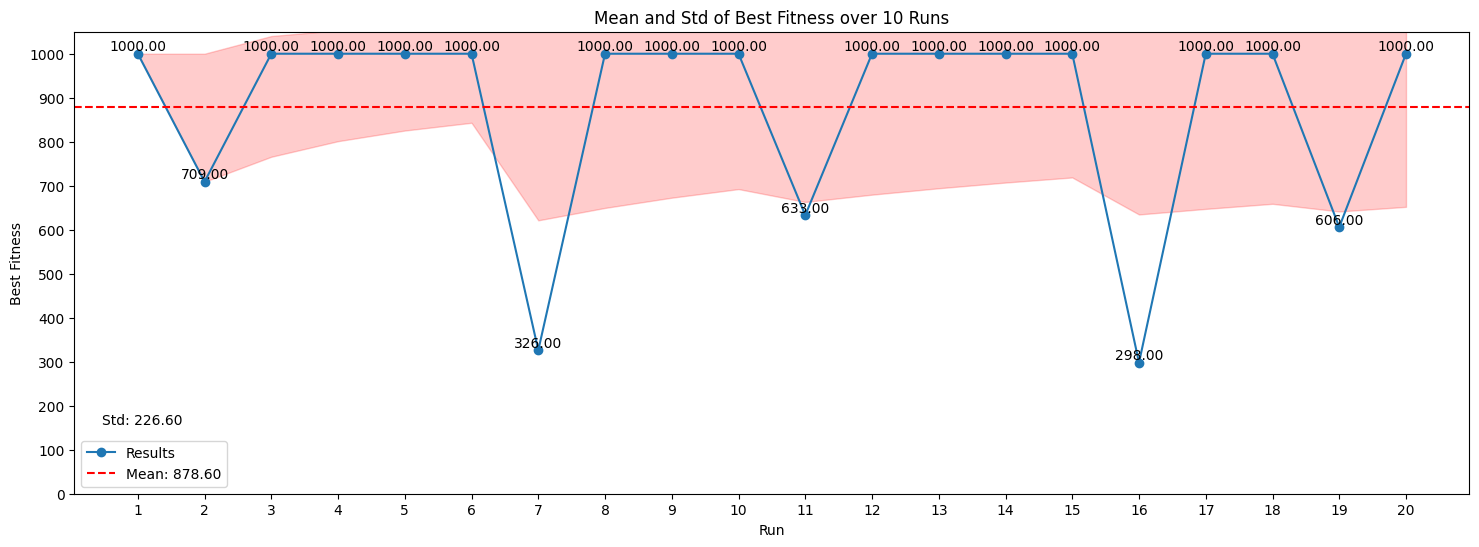

In [20]:
plot_curve(ea, **kwargs)

---
**Question 4 (0-0.25-0.5 pt):** Please comment on the average behavior of your algorithm. How did the average results and standard deviations look? Did your algorithm converge all the time to the best fitness?

**Answer:** Running the ```plot_curve()``` each time leads to a different behavior of the alogorithm. The results shows that they are either perfect (with fitness 1000.0) or fall at middle phase (most failures stop before 600). The average results and std are shown in the figure above, where the average result is high but the distribution is highly unstable. The alogirhtm is not converging with strong oscillation.